In [14]:
def Time_Series_Automation():
        
    ##Import Required Libraries
    import pandas as pd
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    import numpy as np
    import glob
    import shap
    from prophet import Prophet
    import xgboost as xgb
    from xgboost import XGBRegressor
    from sklearn.ensemble import RandomForestRegressor, StackingRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import ParameterGrid, GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    from plotly.subplots import make_subplots
    import plotly.graph_objects as px
    import plotly.graph_objects as go
    
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings("ignore")
    import logging
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)  
    logging.getLogger('prophet').setLevel(logging.WARNING) 
    import os
    import random
    import tensorflow as tf
    import warnings
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
    tf.get_logger().setLevel('ERROR')
    tf.autograph.set_verbosity(0)
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    os.environ['PYTHONHASHSEED'] = '42'
    # For XGBoost
    xgb.set_config(verbosity=0)
    
    import pyodbc
    import optuna
    import random
    
    from datetime import datetime, timedelta
    
    ### Data Preprocessing Functions
    
    class database_utils:
        def __init__(self, server = '3.209.89.110', port=1426, database='master', user='Att_rlo_user', password="optiplex320$"):
            self.server = server
            self.port = port
            self.database = database
            self.user = user
            self.password = password
        def db_open(self):
            print(self.server, self.port, self.database, self.user, self.password)
            conn = pyodbc.connect(Driver="{ODBC Driver 17 for SQL Server}",
                                Server=self.server,
                                Database=self.database,
                                Port=self.port,
                                user=self.user,
                                password=self.password)
            cursor = conn.cursor()
            print('done connection')
            return cursor, conn
    
        #Executes a SQL query and returns the result as a DataFrame.
    
        def from_db(self, query):
            #cursor, conn = db_open(server, Port, Database, user, password)
            cursor, conn = self.db_open()
            df = pd.read_sql_query(query, conn)
            self.db_close(cursor, conn)
            return df
        def db_close(self, cursor, conn):
            cursor.close()
            conn.close()
    
    
    
    
    db = database_utils()
    
    # Fetches purchase order data for a specific item.
    def read_table_PO(x):
        
        #query = f"SELECT FROM_ORG_CODE as Region, ITEM_NUMBER, SUM(ORDERED_QUANTITY)as Quantity ,SHIPDATE FROM  tblDATAWHSE_MINMATSHIPSTRK WHERE ITEM_NUMBER = '{x}' AND FROM_ORG_CODE = 'SW1'GROUP BY MONTH, FROM_ORG_CODE, ITEM_NUMBER ,SHIPDATE ORDER BY SHIPDATE  "
    #     query = f"SELECT a1.Region,a1.ITEM_NUMBER, sum(a1.Quantity) as Quantity, a1.SHIPDATE from (SELECT DEL_REGION as Region, ITEM as ITEM_NUMBER, cast(H_CREATE as date) as SHIPDATE, SUM(D_ORD) AS 'Quantity' FROM tblFRCST_WLN_POS_DS_temp  where ITEM  = '{x}' AND DEL_REGION = 'SOUTHWEST' AND H_CLSD = 'CLOSED' AND H_CREATE >='2023-01-01' GROUP BY ITEM, H_CREATE, DEL_REGION, H_CREATE) a1 GROUP BY a1.ITEM_NUMBER, a1.Region, a1.SHIPDATE ORDER BY a1.ITEM_NUMBER, a1.SHIPDATE"
    #     query = f"""SELECT a1.Region,a1.ITEM_NUMBER, sum(a1.Quantity) as Quantity, a1.SHIPDATE 
    # from (SELECT DEL_REGION as Region, ITEM as ITEM_NUMBER, cast(H_CREATE as date) as SHIPDATE, SUM(D_ORD) AS 'Quantity' FROM [10.0.4.251].[Broadband_Wireline_NWMM].[dbo].[tblFRCST_WLN_POS_B2B]
    # where ITEM  = '{x}' AND DEL_REGION IN ('MIDWEST' ,'WEST') AND H_CLSD = 'CLOSED' AND  ROUTE = 'DRCT' AND H_CREATE >='2020-01-01'  AND  RCPT_DATE IS NOT NULL
    # GROUP BY ITEM, H_CREATE, DEL_REGION, H_CREATE) a1 
    # GROUP BY a1.ITEM_NUMBER, a1.Region, a1.SHIPDATE 
    # ORDER BY a1.ITEM_NUMBER, a1.SHIPDATE"""
        
        query = f"""SELECT a1.Region,a1.ITEM_NUMBER, sum(a1.Quantity) as Quantity, a1.SHIPDATE 
    from (SELECT DEL_REGION as Region, ITEM as ITEM_NUMBER, cast(H_CREATE as date) as SHIPDATE, SUM(D_ORD) AS 'Quantity' FROM [10.0.4.251].[Broadband_Wireline_NWMM].[dbo].[tblFRCST_WLN_POS_B2B]
    where ITEM  = '{x}' AND DEL_REGION = 'SOUTHWEST' AND H_CREATE >='2020-01-01'  AND  RCPT_DATE IS NOT NULL
    GROUP BY ITEM, H_CREATE, DEL_REGION, H_CREATE) a1 
    GROUP BY a1.ITEM_NUMBER, a1.Region, a1.SHIPDATE 
    ORDER BY a1.ITEM_NUMBER, a1.SHIPDATE"""
        
        df_all = db.from_db(query)
        return df_all
    
    
    #  Fetches sales order data for a specific item.
    def read_table_SO(x):
        
    #     query = f"""SELECT SHIP_ORG as Region,ITEM, SUM(ICM_TRX_QTY) as Quantity , CAST(H_CREATE AS DATE) as SHIPDATE 
    # FROM [10.0.4.251].[Broadband_Wireline_NWMM].[dbo].[tblFRCST_WLN_SALESORDERS] 
    # WITH(NOLOCK) WHERE ITEM = '{x}' AND SHIP_ORG IN ('MW1','WE3') AND ROUTE = 'CENT' GROUP BY  SHIP_ORG, ITEM ,CAST(H_CREATE AS DATE) ORDER BY SHIPDATE
    # """  
        query = f"""SELECT SHIP_ORG as Region,ITEM, SUM(ICM_TRX_QTY) as Quantity , CAST(H_CREATE AS DATE) as SHIPDATE 
    FROM [10.0.4.251].[Broadband_Wireline_NWMM].[dbo].[tblFRCST_WLN_SALESORDERS] 
    WITH(NOLOCK) WHERE ITEM = '{x}'  AND SHIP_ORG = 'SW1'  GROUP BY  SHIP_ORG, ITEM ,CAST(H_CREATE AS DATE) ORDER BY SHIPDATE
    """           
        df_all = db.from_db(query)
        return df_all
    
    # Processes purchase and sales order data for each SKU.
    
    SKU = [
  
"ATT.100083026"]
    
    # Function to replace extreme outliers with rolling median
    def replace_outliers_iteratively(data, column, window_size=3, iqr_multiplier=2):
        data = data.copy()
        values = data[column].values  # Convert column to numpy array
        
        # Step 1: Calculate global IQR to flag gross outliers
        Q1_global = pd.Series(values).quantile(0.25)
        Q3_global = pd.Series(values).quantile(0.75)
        IQR_global = Q3_global - Q1_global
        lower_bound_global = Q1_global - iqr_multiplier * IQR_global
        upper_bound_global = Q3_global + iqr_multiplier * IQR_global
        
        print(f"Global IQR: Lower Bound = {lower_bound_global}, Upper Bound = {upper_bound_global}")
        
        #  Replace outliers iteratively using rolling median
        for i in range(len(values)):
            if values[i] < lower_bound_global or values[i] > upper_bound_global:  # Flagged as outlier
                start_idx = max(0, i - window_size + 1)
                window = values[start_idx:i+1]  # Exclude the current outlier value
                
                # Replace only if there is enough data in the window
                if len(window) > 0:
                    rolling_median = pd.Series(window).median()
                   # print(f"Replacing outlier {values[i]} at index {i} with median {rolling_median}")
                    values[i] = rolling_median
        
        data[column] = values  # Update the column with corrected values
        return data
    
    # Function to dynamically handle missing values
    def dynamic_missing_value_handler(data, column):
       
        skewness = data[column].skew()
        
        if abs(skewness) < 0.5:  # Normally distributed
            print(f"Imputing missing values in '{column}' with MEAN (normal distribution detected).")
            return data[column].fillna(data[column].mean())
        elif 0.5 <= abs(skewness) <= 2:  # Moderately skewed
            print(f"Imputing missing values in '{column}' with MEDIAN (moderate skewness detected).")
            return data[column].fillna(data[column].median())
        else:  # Highly skewed
            print(f"Imputing missing values in '{column}' with MODE (high skewness detected).")
            return data[column].fillna(data[column].mode()[0])
    
    # Function to replace zero values with linear interpolation
    def replace_zeros_with_linear(data, column):
        # Replace zeros with NaN for interpolation
        data[column] = data[column].replace(0, np.nan)
         
        # Perform linear interpolation
        data[column] = data[column].interpolate(method='linear')
        
        return data
    
    # Function for Getting last date of the last month
        
    def get_last_date_of_previous_month():
        today = datetime.today()
        first_day_of_current_month = today.replace(day=1)
        last_day_of_previous_month = first_day_of_current_month - timedelta(days=1)
        return last_day_of_previous_month
        
    
    def is_predictions_constant(predictions, tolerance=2.0):
        # Initialize a variable to count the number of predictions with small changes
        count = 0
    
        # Loop through the predictions and calculate the percentage change between consecutive values
        for i in range(len(predictions) - 1):
            percent_change = abs((predictions[i+1] - predictions[i]) / predictions[i]) * 100
            
            # If the percentage change is less than or equal to the tolerance, increment the count
            if percent_change <= tolerance:
                count += 1
    
        # Return the count of small changes for further comparison in the calling process
        return count
    
        
    # Created the dataframe to store the final results.
    results_df = pd.DataFrame(columns=["Dataset", "Model", "MAPE", "MSE", "RMSE"])
    
    # Initialize empty DataFrame to store the final results
    Final_Result_df = pd.DataFrame()
    
    
    ### Making Connection with database and fetching data
    
    # Initializes the database connection parameters.
    
    
    non_zero_months_info = []
    Count_of_months=[]
    skus_with_large_jumps = []
    
    for i in range (0,len(SKU)): 
        
        print('FORECAST GENERATION FOR THE SKU : ', SKU[i])   
       
        PO_table = read_table_PO(SKU[i])
        SO_table = read_table_SO(SKU[i])
       
        #### Combining Two tables PO AND SO
    
        PO_table.drop(['Region','ITEM_NUMBER'] , axis = 1 , inplace = True)        
        PO_table['SHIPDATE'] = pd.to_datetime(PO_table['SHIPDATE'])
        SO_table.drop(['Region','ITEM'] , axis = 1 , inplace = True)
        SO_table['SHIPDATE'] = pd.to_datetime(SO_table['SHIPDATE'])
        
        
        # Create DataFrames
        SO_table = pd.DataFrame(SO_table)
        print("SO_table")
        print(SO_table)
        PO_table = pd.DataFrame(PO_table)
        print("PO_table")
        print(PO_table)
        # Initialize PM as an empty DataFrame
        PM = pd.DataFrame()
        
        # Check if the length of SO_table is less than or equal to 5
        if len(SO_table) <= 5:
            # If SO_table has 5 or fewer entries, use only PO_table
            PM = PO_table.copy()
        else:
            # Sort both tables by SHIPDATE
            SO_table = SO_table.sort_values(by='SHIPDATE').reset_index(drop=True)
            PO_table = PO_table.sort_values(by='SHIPDATE').reset_index(drop=True)
        
            # Find the last SHIPDATE in both tables
            last_so_date = SO_table['SHIPDATE'].max()
            last_po_date = PO_table['SHIPDATE'].max()
        
            # Additional condition: Check if the last 'po' date is less than the first 'so' date
            first_so_date = SO_table['SHIPDATE'].min()
            if last_po_date < first_so_date and len(SO_table) > 5:
                # Concatenate the entire SO_table and PO_table
                PM = pd.concat([SO_table, PO_table], ignore_index=True)
            elif last_so_date == last_po_date:
                # Find the first SHIPDATE in PO_table
                first_po_date = PO_table['SHIPDATE'].min()
        
                # Filter SO_table to include only entries with SHIPDATE less than the first date in PO_table
                SO_filtered = SO_table[SO_table['SHIPDATE'] < first_po_date]
        
                # Concatenate the filtered SO_table and the entire PO_table
                PM = pd.concat([SO_filtered, PO_table], ignore_index=True)
            else:
                # Filter PO_table to include only entries after the last date in SO_table
                PO_filtered = PO_table[PO_table['SHIPDATE'] > last_so_date]
        
                # Concatenate SO_table and the filtered PO_table
                PM = pd.concat([SO_table, PO_filtered], ignore_index=True)
    
                    ################
        # Sort the final DataFrame by SHIPDATE and reset index
        PM = PM.sort_values(by='SHIPDATE').reset_index(drop=True)
        print("Final_Concatenated_Data")
        print(PM)

        # keeping data separately without preprocessing to add actual values in result.
        data_a=PM.copy()
        data_a['SHIPDATE'] = pd.to_datetime(data_a['SHIPDATE'])
        data_a.rename(columns={'SHIPDATE': 'ds', 'Quantity': 'y'}, inplace=True)
        # Convert daily data into monthly data
        data_a = data_a.resample('M', on='ds').sum().reset_index()
        print("data_a(before_preprocessing)")
        print(data_a)
                ###################
        
        print(" ")
        print("Data get loaded successfully")
        print(" ")
    
        print("Graphical view of Purchase Order and Sales Order Data")
     
        ## Separate graph of Sale and Purchase data        
        # Create figure with 2 subplots
        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
        
        # Add PO and SO data traces to the first subplot
        for data, name, color in [(PO_table, 'PO', 'orange'), (SO_table, 'SO', 'skyblue')]:
            fig.add_trace(go.Scatter(x=data['SHIPDATE'], y=data['Quantity'], mode='lines', name=name, line=dict(color=color, width=1, dash='solid'), line_shape='spline'), row=1, col=1)
        
        # Add PM data trace to the second subplot
        fig.add_trace(go.Scatter(x=PM['SHIPDATE'], y=PM['Quantity'], mode='lines', name='PM', line=dict(color='green', width=1), line_shape='spline'), row=2, col=1)
        
        # Update layout
        fig.update_layout(
            title=f"REVISED HISTORICAL DATA of {SKU[i]}", title_font=dict(size=15, color='black'),
            xaxis_title="Date", yaxis_title="Historical Data", 
            xaxis=dict(showline=True, linewidth=3, linecolor='black', mirror=True, ticklabelstep=1, showgrid=False),
            yaxis=dict(showline=True, linewidth=3, linecolor='black', mirror=True, showgrid=False),
            xaxis2=dict(showgrid=False),
            yaxis2=dict(showgrid=False), 
            legend=dict(font=dict(size=14, color='black'), orientation='h', x=0.5, y=1.05, xanchor='center'),
            template="plotly_white", width=1100, height=800, plot_bgcolor='rgba(0, 0, 0, 0)', hovermode="closest"
        )
        
        # Show the plot and save it
        fig.show()
    
        print(" ")
        print("Preprocessing  Get Started.....")
        print(" ")
        # Store the the data of PM in data named dataframe so i didn't need to change df name for below code.
        data=PM
        
        # Preprocessing
        # Get the last date of the previous month
        last_date = get_last_date_of_previous_month()
        # Filter the dataset
        filtered_data = data[data['SHIPDATE'] <= last_date]
        
        filtered_data['Quantity'] = dynamic_missing_value_handler(filtered_data, 'Quantity')
        
        # Apply the function to the dataframe
        data = replace_zeros_with_linear(filtered_data, 'Quantity')
        
        # Rename columns for modeling
        data.rename(columns={'SHIPDATE': 'ds', 'Quantity': 'y'}, inplace=True)
    
        # Replace outlier iteratively
        df_corrected = replace_outliers_iteratively(data, 'y', window_size=3, iqr_multiplier=2)
        
        # Convert daily data into monthly data
        data = df_corrected.resample('M', on='ds').sum().reset_index()
        print('data (After_Preprocessing)')
        print(data)
        
        # Count non-zero months
        non_zero_months = (data['y'] > 0).sum()
        Count_of_months.append({'Item_Number': SKU[i], 'Non_Zero_Months': non_zero_months})
        # Check if non-zero months are less than six
        if non_zero_months < 6:
            non_zero_months_info.append({'Item_Number': SKU[i], 'Non_Zero_Months': non_zero_months})
        else:
            # Proceed with further processing
            # Apply the function to the dataframe
            data = replace_zeros_with_linear(data, 'y')
            # Graph to understand the nature of the data
            dataset_name = f"Dataset_{i+1}"
            
            fig = go.Figure()
    
            # Add Original Data with a different color
            fig.add_trace(go.Scatter(x=data['ds'], y=data['y'], mode='lines', name='Original Data', 
                                     line=dict(color='blue', width=1.5, dash='solid'), line_shape='spline'))
            
            # Customize Layout
            fig.update_layout(
                title=f"Nature of {dataset_name} after Outlier treatment (Monthly)", 
                title_font=dict(size=15, color='black', family='Arial'),
                xaxis_title="Date", 
                yaxis_title="Values", 
                xaxis=dict(showgrid=False, gridcolor='lightgray', zeroline=True, zerolinewidth=1, showline=False, linewidth=1, linecolor='black'),
                yaxis=dict(showgrid=False, gridcolor='lightgray', zeroline=True, zerolinewidth=1, showline=False, linewidth=1, linecolor='black'),
                legend=dict(font=dict(size=10, color='black'), orientation='h', x=0.5, xanchor='center', y=1.05),
                template="plotly_white", 
                width=1100, height=500, 
                plot_bgcolor='rgba(255, 255, 255, 1)',  
                hovermode="closest"
            )
            
            fig.show()
            
            print(" ")
            print("Process is going on please wait for some seconds.........")
            print(" ")
            
    
            ## FEATURES
                  
          
            # Features for XGBoost, Random Forest, and Stacking
            data['year'] = data['ds'].dt.year
            data['month'] = data['ds'].dt.month
            data['day'] = data['ds'].dt.day
            data['dayofweek'] = data['ds'].dt.dayofweek
            data['quarter'] = data['ds'].dt.quarter
            data['y_lag1'] = data['y'].shift(1)
            data['y_lag2'] = data['y'].shift(2)
            data['y_lag3'] = data['y'].shift(3)
            data.fillna(data.mean(), inplace=True)
            
            # # Determine the number of rows to include in the test set
            # test_size = 6
            
            # # Split the DataFrame
            # train = data.iloc[:-test_size]  # All rows except the last 'test_size' rows
            # print('Train')
            # print(train)
            # test = data.iloc[-test_size:]   # The last 'test_size' rows
            # print('Test')
            # print(test)

            train_size = int(len(data) * 0.8)
            train = data.iloc[:train_size]
            test = data.iloc[train_size:]

            X_train = train[['year', 'month', 'day', 'dayofweek', 'quarter', 'y_lag1', 'y_lag2', 'y_lag3']]
            y_train = train['y']
            X_test = test[['year', 'month', 'day', 'dayofweek', 'quarter', 'y_lag1', 'y_lag2', 'y_lag3']]
            y_test = test['y']
        
        
        
            ### Hyperparameter Tuning
            
            # Hyperparameter tuning for XGBoost using GridSearchCV
            xgb_param_grid = {
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200, 500],
                'subsample': [0.5, 0.7],
                'colsample_bytree': [0.5, 0.7]
            }
            xgb_grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror'), xgb_param_grid, cv=3, n_jobs=-1)
            xgb_grid_search.fit(X_train, y_train)
            best_xgb_model = xgb_grid_search.best_estimator_
            
            # Hyperparameter tuning for Random Forest using GridSearchCV
            rf_param_grid = {
                'n_estimators': [100, 200, 500],
                'max_depth': [3, 5, 7, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1)
            rf_grid_search.fit(X_train, y_train)
            best_rf_model = rf_grid_search.best_estimator_
            
            # Hyperparameter tuning for Prophet (manual search)
           
            prophet_param_grid = {
                'seasonality_mode': ['additive', 'multiplicative'],
                'changepoint_prior_scale': [0.001, 0.01, 0.1],
                'seasonality_prior_scale': [5, 10, 15]
            }
            best_prophet_mape = float('inf')
            best_prophet = None
            
            for params in ParameterGrid(prophet_param_grid):
                prophet_model = Prophet(**params)
                prophet_model.fit(train[['ds', 'y']])
                forecast = prophet_model.predict(test[['ds']])
                prophet_mape = mean_absolute_percentage_error(test['y'], forecast['yhat']) * 100
                if prophet_mape < best_prophet_mape:
                    best_prophet_mape = prophet_mape
                    best_prophet = prophet_model
                    best_params = params
             
        
        
            
            # Evaluate the models
            
            # Evaluate Prophet
            forecast = best_prophet.predict(test[['ds']])
            prophet_mape = mean_absolute_percentage_error(test['y'], forecast['yhat']) * 100
            prophet_mse = mean_squared_error(test['y'], forecast['yhat'])
            prophet_rmse = np.sqrt(prophet_mse)
            
            # Evaluate XGBoost
            xgb_preds = best_xgb_model.predict(X_test)
            xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds) * 100
            xgb_mse = mean_squared_error(y_test, xgb_preds)
            xgb_rmse = np.sqrt(xgb_mse)
            
            # Evaluate Random Forest
            rf_preds = best_rf_model.predict(X_test)
            rf_mape = mean_absolute_percentage_error(y_test, rf_preds) * 100
            rf_mse = mean_squared_error(y_test, rf_preds)
            rf_rmse = np.sqrt(rf_mse)
            
            
            # Stacking
            # Generate predictions from Prophet model
            prophet_predictions_train = best_prophet.predict(train[['ds']])['yhat']
            prophet_predictions_test = best_prophet.predict(test[['ds']])['yhat']
            
            # Generate predictions from XGBoost model
            xgb_predictions_train = best_xgb_model.predict(X_train)
            xgb_predictions_test = best_xgb_model.predict(X_test)
            
            # Generate predictions from Random Forest model
            rf_predictions_train = best_rf_model.predict(X_train)
            rf_predictions_test = best_rf_model.predict(X_test)
            
            # Combine the predictions from the base models
            X_stack_train = np.column_stack((prophet_predictions_train, xgb_predictions_train, rf_predictions_train))
            X_stack_test = np.column_stack((prophet_predictions_test, xgb_predictions_test, rf_predictions_test))
            
            # Train a meta-model (Linear Regression) using the predictions from the base models
            meta_model = LinearRegression()
            meta_model.fit(X_stack_train, y_train)
            
            # Make final predictions using the meta-model
            stacked_predictions_test = meta_model.predict(X_stack_test)
            
            # Evaluate the stacked model's performance
            stacking_mape = mean_absolute_percentage_error(y_test, stacked_predictions_test) * 100
            stacking_mse = mean_squared_error(y_test, stacked_predictions_test)
            stacking_rmse = np.sqrt(stacking_mse)

                                    
            ### Adding Results and Future Predictions


            # Add Results
            dataset_name = f"Dataset_{i+1}"
            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    "Dataset": [dataset_name]*4,
                    "Model": ["Prophet", "XGBoost", "Random Forest", "Stacking"],
                    "MAPE": [prophet_mape, xgb_mape, rf_mape, stacking_mape],
                    "MSE": [prophet_mse, xgb_mse, rf_mse,stacking_mse],
                    "RMSE": [prophet_rmse, xgb_rmse, rf_rmse, stacking_rmse]
                })
            ], ignore_index=True)
        
        
            # Generate future dates 
             # Generate future dates 
            future_dates = pd.date_range(start=data['ds'].iloc[-1], periods=36, freq='M')[1:]
            
    
            
            # Prepare future data
            future_data = pd.DataFrame({
                'ds': future_dates,
                'year': future_dates.year,
                'month': future_dates.month,
                'day': future_dates.day,
                'dayofweek': future_dates.dayofweek,
                'quarter': future_dates.quarter,
                'y_lag1': [data['y'].iloc[-1]]*len(future_dates),
                'y_lag2': [data['y'].iloc[-2]]*len(future_dates),
                'y_lag3': [data['y'].iloc[-3]]*len(future_dates)
            })
            # Convert 'ds' column to integer 
            future_data['ds'] = future_data['ds'].astype('int64') / 10**9
            
            # Generate predictions for future dates with Prophet
            future_prophet_preds = best_prophet.predict(pd.DataFrame({'ds': future_dates}))['yhat']
            
            # Exclude 'ds' column for XGBoost and Random Forest predictions
            future_data_no_ds = future_data.drop(columns=['ds'])
            
            future_xgb_preds = best_xgb_model.predict(future_data_no_ds)
            future_rf_preds = best_rf_model.predict(future_data_no_ds)
            
            # Convert DataFrame to NumPy array and reshape
            future_data_no_ds_array = future_data_no_ds.values  # Convert to NumPy array
            future_data_no_ds_reshaped = future_data_no_ds_array.reshape((future_data_no_ds_array.shape[0], future_data_no_ds_array.shape[1], 1))
                    
            # Create stacking dataset for future predictions
            X_stack_future = np.column_stack((future_prophet_preds, future_xgb_preds, future_rf_preds))
            
        
            
            # Compare MAPE scores to select the best model
            model_mape_scores = {
                "Prophet": prophet_mape,
                "XGBoost": xgb_mape,
                "Random Forest": rf_mape,
                "Stacking": stacking_mape
            }
           
    
            
            # Find the model with the lowest MAPE
            best_model_name = min(model_mape_scores, key=model_mape_scores.get)
            print(f"\nBest Model Based on MAPE: {best_model_name}")
            # best_model_name = "Random Forest"
        
        
            # data Preparation for retraining
            Features = data[['year', 'month', 'day', 'dayofweek', 'quarter', 'y_lag1', 'y_lag2', 'y_lag3']]
            Target = data['y']
    
    
            
                                 ####################### Stacking #########################
    
            # Defining the stacking outside the loop
            # Use stacking model instead if LSTM is too constant
            prophet_predictions_full = best_prophet.predict(data[['ds']])['yhat']
            xgb_predictions_full = best_xgb_model.predict(Features)
            rf_predictions_full = best_rf_model.predict(Features)
            
            
            # Combine predictions from all models (Prophet, XGBoost, RF, LSTM) into one feature matrix for stacking
            X_stack_full = np.column_stack((prophet_predictions_full, xgb_predictions_full, rf_predictions_full))
            
            # Retrain the stacking model (meta_model) on the full dataset
            meta_model.fit(X_stack_full, Target)
            
                    
                             ######################### Stacking  #########################
    
               
            
            # Retrain the best model on the entire dataset (train + test)
            if best_model_name == "Prophet":
                best_prophet = Prophet(**best_params)
                best_prophet.fit(data[['ds', 'y']])
                future_best_model_preds = best_prophet.predict(pd.DataFrame({'ds': future_dates}))['yhat']
                
                # Check if there are any negative predictions
                if any(future_best_model_preds < 0):
                    print(" ")
                    print("Negative predictions from Prophet. Switching to Stacking.")
                    print(" ")
                    # Set the model to Stacking directly
                    best_model_name = "Stacking"
                    
                    # Make predictions using the trained stacking model
                    future_best_model_preds = meta_model.predict(X_stack_future)
    
                    # Replace negative predictions with zeros
                    future_best_model_preds[future_best_model_preds < 0] = 0
                 
                else:
                    # If no negative predictions, continue with Prophet
                    print(" ")
                    print("Prophet predictions are valid. Continuing with Prophet.")
                    print(" ")
                    best_model_name == "Prophet"
    
                    future_best_model_preds = best_prophet.predict(pd.DataFrame({'ds': future_dates}))['yhat']
    
                    # Call the function to get the count of small changes in predictions
                    count = is_predictions_constant(future_best_model_preds)
                
                    # Check if the number of small changes is greater than or equal to half of the total predictions
                    if count >= len(future_best_model_preds) // 2:
                        
                        print("Prophet predictions are too constant. Switching to Stacking.")
                        print(" ")
                        # Set the model name to Stacking
                        best_model_name = "Stacking"
                        
                        # Make predictions using the trained stacking model
                        future_best_model_preds = meta_model.predict(X_stack_future)
                        
                        # Replace negative predictions with zeros
                        future_best_model_preds[future_best_model_preds < 0] = 0
                     
                    else:
                        print("Prophet predictions are valid. Finalizing results with Prophet.")
                        print(" ")
                        # Set the model name to LSTM
                        best_model_name = "Prophet"
                        
                        # Use the original XGBoost predictions if they are valid
                        future_best_model_preds = best_xgb_model.predict(future_data_no_ds)
                        
                        future_best_model_preds = best_prophet.predict(pd.DataFrame({'ds': future_dates}))['yhat']
                        
            
            elif best_model_name == "XGBoost":
                best_xgb_model.fit(Features, Target)
                future_best_model_preds = best_xgb_model.predict(future_data_no_ds)
    
                # Call the function to get the count of small changes in predictions
                count = is_predictions_constant(future_best_model_preds)
            
                # Check if the number of small changes is greater than or equal to half of the total predictions
                if count >= len(future_best_model_preds) // 2:
                    print("XGBoost predictions are too constant. Switching to Stacking.")
                    print(" ")
                    # Set the model name to Stacking
                    best_model_name = "Stacking"
                    
                    # Make predictions using the trained stacking model
                    future_best_model_preds = meta_model.predict(X_stack_future)
                    
                    # Replace negative predictions with zeros
                    future_best_model_preds[future_best_model_preds < 0] = 0
    
                else:
                    print("XGBoost predictions are valid. Finalizing results with XGBoost.")
                    print(" ")
                    # Set the model name to LSTM
                    best_model_name = "XGBoost"
                    
                    # Use the original XGBoost predictions if they are valid
                    future_best_model_preds = best_xgb_model.predict(future_data_no_ds)
                    
                    # Replace negative predictions with zeros
                    future_best_model_preds[future_best_model_preds < 0] = 0
            
                
                
            elif best_model_name == "Random Forest":
                best_rf_model.fit(Features, Target)
                future_best_model_preds = best_rf_model.predict(future_data_no_ds)
                
                # Call the function to get the count of small changes in predictions
                count = is_predictions_constant(future_best_model_preds)
            
                # Check if the number of small changes is greater than or equal to half of the total predictions
                if count >= len(future_best_model_preds) // 2:
                    print("Random Forest predictions are too constant. Switching to Stacking.")
                    print(" ")
                    # Set the model name to Stacking
                    best_model_name = "Stacking"
                    
                    
                    # Make predictions using the trained stacking model
                    future_best_model_preds = meta_model.predict(X_stack_future)
                    
                    # Replace negative predictions with zeros
                    future_best_model_preds[future_best_model_preds < 0] = 0      
            
                else:
                    print("Random Forest predictions are valid. Finalizing results with Random Forest.")
                    print(" ")
                    # Set the model name to LSTM
                    best_model_name = "Random Forest"
                    
                    # Use the original XGBoost predictions if they are valid
                    future_best_model_preds = best_rf_model.predict(future_data_no_ds)
                    
                    # Replace negative predictions with zeros
                    future_best_model_preds[future_best_model_preds < 0] = 0
             
            elif best_model_name == "Stacking":
         
                # Make predictions using the trained stacking model
                future_best_model_preds = meta_model.predict(X_stack_future)
                # Replace negative predictions with zeros
                future_best_model_preds[future_best_model_preds < 0] = 0
                
                    
            # Best and final prediction       
            future_best_model_preds
            future_best_model_preds = [int(round(value)) for value in future_best_model_preds]
    
            # Calculate the percentage change between the last historical data point and the first forecasted value
            last_historic_value = data['y'].iloc[-1]  # Last historical data point
            first_forecast_value = future_best_model_preds[0]  # First forecasted value
            
            # Calculate the percentage change
            pct_change = np.abs((first_forecast_value - last_historic_value) / last_historic_value)
            
            # Define a threshold for detecting large jumps 
            threshold_pct_change = 0.5  # 50% change between last historic data and first forecast
            
            # If the percentage change is larger than the threshold, flag it
            if pct_change > threshold_pct_change:
                print(f"Large jump in forecast detected for SKU: {SKU[i]}")
                print(" ")
                logging.warning(f"Large jump detected for SKU: {SKU[i]}. Percentage change: {pct_change:.2f}")
                
                # Store the SKU with large jump for further inspection
                skus_with_large_jumps.append({"ITEM_NUMBER":SKU[i]})
    
    
    
            ############################
    
            # Get today's date
            today_date = datetime.today().date()
            
            # Format the date as yyyy-mm-dd
            ReportDate = today_date.strftime('%Y-%m-%d')
            ReportDate
                    
            ###########################
            
            # Append the results to the forecasted_results DataFrame
            forecasted_results =pd.DataFrame({
                    "OIN": SKU[i],
                    "MONTH": future_dates,
                    "Value": future_best_model_preds,
                    "Flag": ["Forecasted_Values"] * len(future_dates),
                    "Model": [best_model_name] * len(future_dates),
                    "Accuracy": [model_mape_scores[best_model_name]] * len(future_dates) ,
                    "ReportDate": (ReportDate)
                })
            print()
            print()
            
    
            # Get today's date and the start of the current month
            today = datetime.today()
            start_of_current_month = today.replace(day=1)
            
            # Filter the forecasted results to get the next 12 months from the start of the current month
            filtered_forecasted_results = forecasted_results[
                (forecasted_results['MONTH'] >= start_of_current_month) & 
                (forecasted_results['MONTH'] < start_of_current_month + pd.DateOffset(months=12))]
    
            filtered_forecasted_results['MONTH'] = filtered_forecasted_results['MONTH'].dt.strftime('%Y-%m-%d')
            
            # Finding the past data(Taking care that if we didn't have the data for last some month then for that month values will go as zero)
            
            # Get today's date
            today = datetime.today()
            
            # Calculate the last day of the previous month
            last_day_prev_month = today.replace(day=1) - timedelta(days=1)
            
            # Calculate the first day of the month 11 months before the previous month
            start_date = last_day_prev_month - pd.DateOffset(months=11)
            
            # Create a date range for the last 12 months with end-of-month dates
            date_range = pd.date_range(start=start_date, end=last_day_prev_month, freq='ME').normalize()
                        
            # Initialize a DataFrame with the date range and fill missing values with zeros
            full_data = pd.DataFrame({'ds': date_range})
            full_data['y'] = 0
            
            # Merge with your existing data to fill in the actual values
            merged_data = pd.merge(full_data, data_a[['ds', 'y']], on='ds', how='left')
            merged_data['y'] = merged_data['y_y'].fillna(0).astype(int)
            merged_data = merged_data[['ds', 'y']]
            
            # Extracting the last 12 months
            Past_date_12 = merged_data['ds'].dt.strftime('%Y-%m-%d').values.flatten()
            Past_value_12 = merged_data['y'].values.flatten()
            
            # Convert values to integers
            Past_value_12 = [int(round(value)) for value in Past_value_12]

            Past_12_month_data =pd.DataFrame({
                    "OIN": SKU[i],
                    "MONTH": Past_date_12,
                    "Value": Past_value_12,
                    "Flag": ["Historical_Values"] * len(Past_date_12),
                    "Model": [best_model_name] * len(Past_date_12),
                    "Accuracy":[model_mape_scores[best_model_name]] * len(Past_date_12),
                    "ReportDate": (ReportDate)
                })
    
            # Combine past 12 month data and forecasted results for the current SKU
            Combined_df = pd.concat([Past_12_month_data, filtered_forecasted_results], ignore_index=True)
        
            # Append the combined results to the final DataFrame
            Final_Result_df = pd.concat([Final_Result_df, Combined_df], ignore_index=True)
    
        
            Final_Result_df.to_csv('Forecast.With.January(4).csv',index=False)
            ### Adding Model Predictions and Plotting
            
            # Plot for the current dataset (Prophet, XGBoost, Random Forest, Stacking)
            fig = go.Figure()
    
            # Add Original Data
            fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Original Data', 
                                     line=dict(color='royalblue', width=1.5, dash='solid'), line_shape='spline'))
            
            # Add Model Predictions
            fig.add_trace(go.Scatter(x=test['ds'], y=forecast['yhat'], mode='lines', name='Prophet', 
                                     line=dict(color='orange', width=1.5, dash='solid'), line_shape='spline'))
            fig.add_trace(go.Scatter(x=test['ds'], y=xgb_preds, mode='lines', name='XGBoost', 
                                     line=dict(color='green', width=1.5, dash='solid'), line_shape='spline'))
            fig.add_trace(go.Scatter(x=test['ds'], y=rf_preds, mode='lines', name='Random Forest', 
                                     line=dict(color='red', width=1.5, dash='solid'), line_shape='spline'))
            fig.add_trace(go.Scatter(x=test['ds'], y=stacked_predictions_test, mode='lines', name='Stacking', 
                                     line=dict(color='yellow', width=1.5, dash='solid'), line_shape='spline'))
            
            
            # Customize Layout
            fig.update_layout(
                title=f"Model Comparison for {dataset_name}: Original Data vs Predictions", 
                title_font=dict(size=24, color='black', family='Arial'),
                xaxis_title="Date", 
                yaxis_title="Values", 
                xaxis=dict(showgrid=False, gridcolor='lightgray', zeroline=True, zerolinewidth=1, showline=False, linewidth=1, linecolor='black'),
                yaxis=dict(showgrid=False, gridcolor='lightgray', zeroline=True, zerolinewidth=1, showline=False, linewidth=1, linecolor='black'),
                legend=dict(font=dict(size=14, color='black'), orientation='h', x=0.5, xanchor='center', y=1.05),
                template="plotly_white", 
                width=1100, height=500, 
                plot_bgcolor='rgba(255, 255, 255, 1)',  # white background
                hovermode="closest"
            )
            
            fig.show()
            
            
            
            # Extract the last 20 records of the original data (both 'ds' and 'y' columns)
            last_20_records = data.tail(20)[['ds', 'y']]  
            
            

            Filtered_Result=pd.DataFrame({'ds':filtered_forecasted_results['MONTH'],
                                          'y':filtered_forecasted_results['Value']})
            # Convert 'ds' to datetime format if it's not already
            Filtered_Result['ds'] = pd.to_datetime(Filtered_Result['ds'])
            
            # Normalize the 'ds' column to remove the time component
            Filtered_Result['ds'] = Filtered_Result['ds'].dt.normalize()
           
        
            Combined_df_ = pd.concat([last_20_records.iloc[-1:],Filtered_Result], ignore_index=True)
           
            print()
            # Plot for the current dataset (Prophet, XGBoost, Random Forest, Stacking)
            fig = go.Figure()
    
            # Add Original Data
            fig.add_trace(go.Scatter(x=last_20_records['ds'], y=last_20_records['y'], mode='lines', 
                                     name='Original Data', line=dict(color='royalblue', width=1.5, dash='solid'), line_shape='spline'))
            
            # Add Model Predictions
            fig.add_trace(go.Scatter(x=Combined_df_['ds'], y=Combined_df_['y'], mode='lines', 
                                     name=best_model_name, line=dict(color='green', width=1.5, dash='solid'), line_shape='spline'))
            
            # Customize Layout
            fig.update_layout(
                title=f"Model Comparison: Original Data of {dataset_name} vs Predictions", 
                title_font=dict(size=12, color='black', family='Arial'),
                xaxis_title="Date", 
                yaxis_title="Values", 
                xaxis=dict(showgrid=False, gridcolor='lightgray', zeroline=True, zerolinewidth=1, showline=False, linewidth=1, linecolor='black'),
                yaxis=dict(showgrid=False, gridcolor='lightgray', zeroline=True, zerolinewidth=1, showline=False, linewidth=1, linecolor='black'),
                legend=dict(font=dict(size=14, color='black'), orientation='h', x=0.5, xanchor='center', y=1.05),
                template="plotly_white", 
                width=1100, height=500, 
                plot_bgcolor='rgba(255, 255, 255, 1)',  # white background
                hovermode="closest"
            )
            
            fig.show()
        
        
        
    # Item Number Where Forecast Jump high compare to past observation    
    skus_with_large_jumps=pd.DataFrame(skus_with_large_jumps)   
    skus_with_large_jumps.to_csv("Item_Jumps.csv")
        
    # Print Results
    print("Model Evaluation Results:")
    print(results_df)
    
    # Save non-zero months info to CSV
    non_zero_months_df = pd.DataFrame(non_zero_months_info)
    #non_zero_months_df.to_csv('non_zero_months_info(15.).csv', index=False)
    
    # Count of months for each ITEM_NUMBER
    Counts_of_months_for_Item = pd.DataFrame(Count_of_months)         
    #Counts_of_months_for_Item.to_csv('Each_ITEM_month_count(15.).csv', index=False)
    
    print("\12 Months Forecasted Results:")
    print(Final_Result_df)
    
    #results_df.to_csv('All_models_result(15.).csv',index=False)
    
    Final_Result_df.to_csv('Forecast.With.January(4).csv',index=False)

FORECAST GENERATION FOR THE SKU :  ATT.100083026
3.209.89.110 1426 master Att_rlo_user optiplex320$
done connection
3.209.89.110 1426 master Att_rlo_user optiplex320$
done connection
SO_table
     Quantity   SHIPDATE
0         8.0 2022-01-03
1         7.0 2022-01-04
2         6.0 2022-01-05
3         6.0 2022-01-06
4         2.0 2022-01-07
..        ...        ...
495       NaN 2024-02-07
496       NaN 2024-02-08
497       NaN 2024-02-09
498       NaN 2024-02-13
499       NaN 2024-02-14

[500 rows x 2 columns]
PO_table
     Quantity   SHIPDATE
0       150.0 2022-02-01
1       300.0 2022-02-28
2       200.0 2022-05-25
3       200.0 2022-07-15
4       300.0 2022-09-16
..        ...        ...
222       2.0 2025-01-29
223       4.0 2025-01-31
224       7.0 2025-02-04
225       3.0 2025-02-05
226       2.0 2025-02-06

[227 rows x 2 columns]
Final_Concatenated_Data
     Quantity   SHIPDATE
0         8.0 2022-01-03
1         7.0 2022-01-04
2         6.0 2022-01-05
3         6.0 2022-01-06
4 

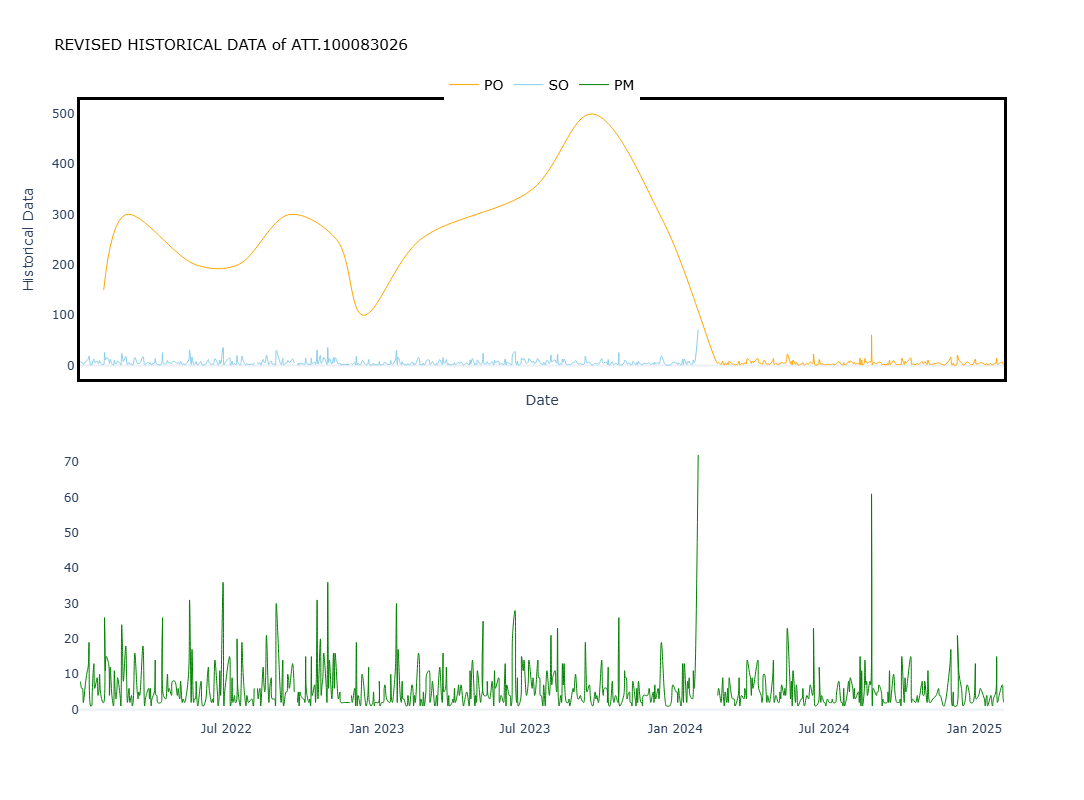

 
Preprocessing  Get Started.....
 
Imputing missing values in 'Quantity' with MODE (high skewness detected).
Global IQR: Lower Bound = -10.0, Upper Bound = 20.0
data (After_Preprocessing)
           ds      y
0  2022-01-31  150.0
1  2022-02-28  157.0
2  2022-03-31  105.0
3  2022-04-30  100.0
4  2022-05-31  105.0
5  2022-06-30  111.0
6  2022-07-31  120.0
7  2022-08-31  102.0
8  2022-09-30  103.0
9  2022-10-31  146.0
10 2022-11-30   94.0
11 2022-12-31   92.0
12 2023-01-31  109.0
13 2023-02-28   82.0
14 2023-03-31  122.0
15 2023-04-30   86.0
16 2023-05-31  103.0
17 2023-06-30  109.0
18 2023-07-31  128.0
19 2023-08-31  127.0
20 2023-09-30   91.0
21 2023-10-31   91.0
22 2023-11-30   82.0
23 2023-12-31   73.0
24 2024-01-31  123.0
25 2024-02-29   47.0
26 2024-03-31   91.0
27 2024-04-30  119.0
28 2024-05-31  105.0
29 2024-06-30   79.0
30 2024-07-31   63.0
31 2024-08-31  135.0
32 2024-09-30   72.0
33 2024-10-31  109.0
34 2024-11-30   53.0
35 2024-12-31   75.0
36 2025-01-31   84.0


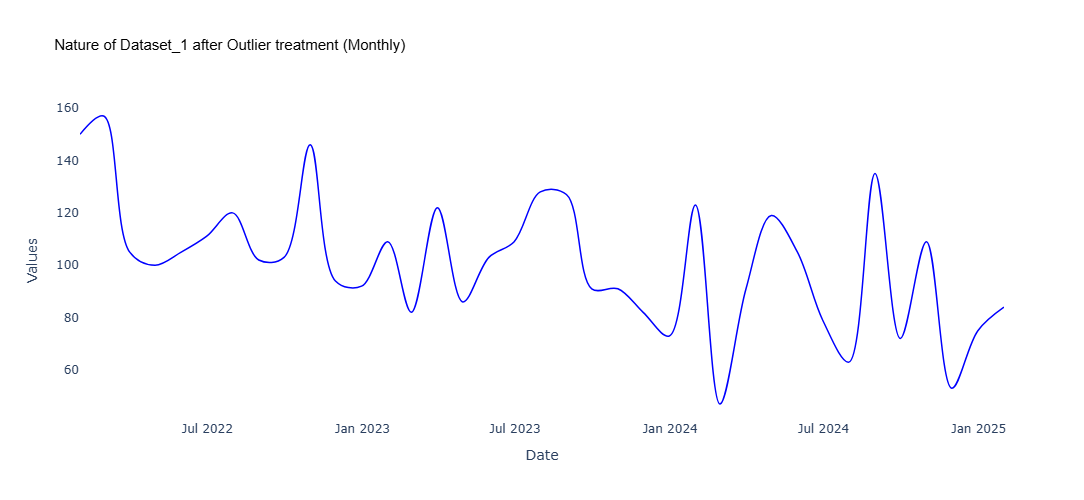

 
Process is going on please wait for some seconds.........
 

Best Model Based on MAPE: Prophet
 
Prophet predictions are valid. Continuing with Prophet.
 
Prophet predictions are valid. Finalizing results with Prophet.
 




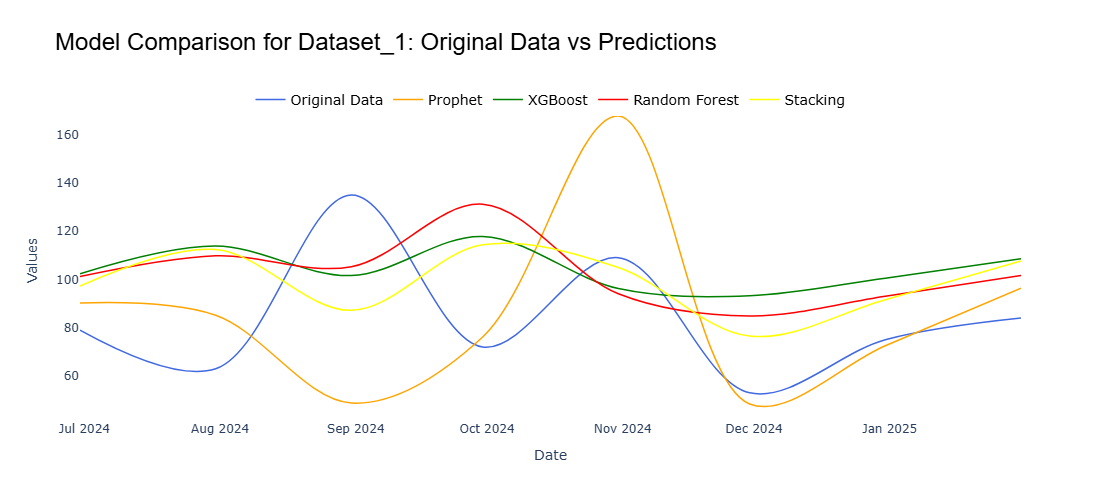

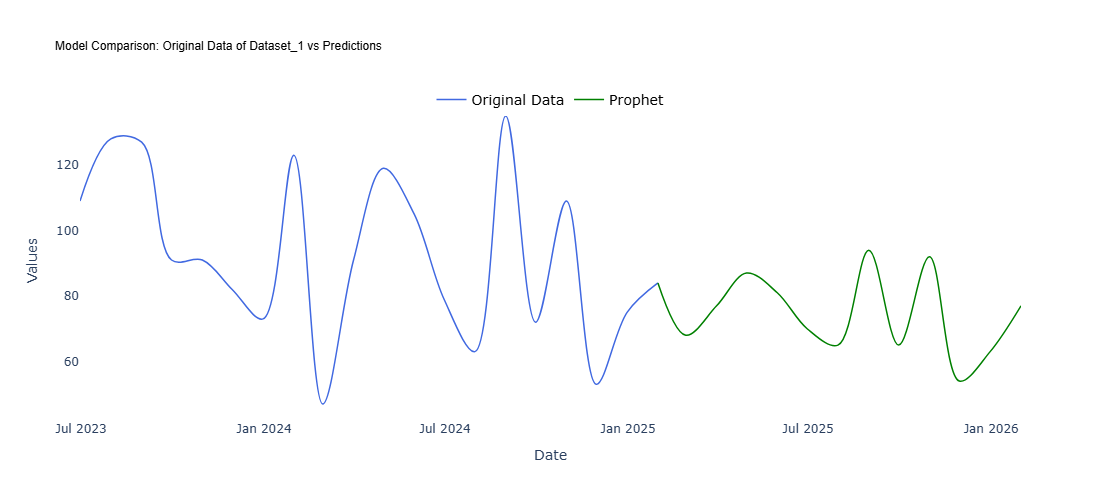

Model Evaluation Results:
     Dataset          Model       MAPE          MSE       RMSE
0  Dataset_1        Prophet  24.955980  1461.806552  38.233579
1  Dataset_1        XGBoost  43.666990  1171.338284  34.224820
2  Dataset_1  Random Forest  40.657381  1117.024493  33.421916
3  Dataset_1       Stacking  36.763338  1031.929118  32.123654

 Months Forecasted Results:
              OIN       MONTH  Value               Flag    Model  Accuracy  ReportDate
0   ATT.100083026  2024-02-29     29  Historical_Values  Prophet  24.95598  2025-02-13
1   ATT.100083026  2024-03-31     91  Historical_Values  Prophet  24.95598  2025-02-13
2   ATT.100083026  2024-04-30    119  Historical_Values  Prophet  24.95598  2025-02-13
3   ATT.100083026  2024-05-31    120  Historical_Values  Prophet  24.95598  2025-02-13
4   ATT.100083026  2024-06-30     95  Historical_Values  Prophet  24.95598  2025-02-13
5   ATT.100083026  2024-07-31     63  Historical_Values  Prophet  24.95598  2025-02-13
6   ATT.100083026  20

In [16]:
Time_Series_Automation()